In [1]:
import multiprocessing

import matplotlib.pyplot as plt
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchvision import transforms

import utils.dlc_practical_prologue as prologue


%load_ext autoreload
%autoreload 2

In [2]:
def load_data(batch_size=20):
    transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Lambda(lambda x: x.div(255))]
    )

    train_input, train_target, train_classes,\
        test_input, test_target, test_classes = prologue.generate_pair_sets(
            1000, transform=transform)

    trainset = TensorDataset(train_input, train_target)
    testset = TensorDataset(test_input, test_target)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers= 1)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, num_workers= 1)
    
    return trainloader, testloader

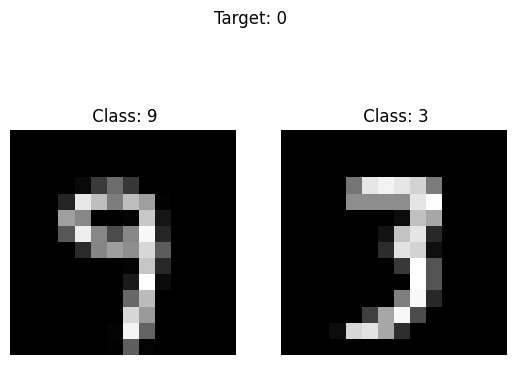

Train input shapetorch.Size([1000, 2, 14, 14])
Train target shapetorch.Size([1000])
Train classes shapetorch.Size([1000, 2])
---
Test input shape torch.Size([1000, 2, 14, 14])
Test target shape torch.Size([1000])
Test classes shape torch.Size([1000, 2])


In [3]:
BATCH_SIZE = 50

transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Lambda(lambda x: x.div(255))]
)

train_input, train_target, train_classes,\
    test_input, test_target, test_classes = prologue.generate_pair_sets(
        1000, transform=transform)


trainset = TensorDataset(train_input, train_target)
testset = TensorDataset(test_input, test_target)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers= 1)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers= 1)


# Plotting the first 5 pairs of images
for i in range(1):
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(train_input[i, j].view(14, 14), cmap='gray')
        # plot the target and its class in the title
        plt.suptitle(f"Target: {train_target[i]}")
        plt.title(f' Class: {train_classes[i, j]}')
        plt.axis('off')
    plt.show()

# print the shapes of the tensors
print(f"Train input shape{train_input.shape}")
print(f"Train target shape{train_target.shape}")
print(f"Train classes shape{train_classes.shape}")
print('---')
print(f"Test input shape {test_input.shape}")
print(f"Test target shape {test_target.shape}")
print(f"Test classes shape {test_classes.shape}")


## Examine data format and normalize

In [4]:
print(train_input[0,1].shape)
print(train_input[0,1].dtype)
print(train_input[0,1].max())
print(train_input[0,1].min())

torch.Size([14, 14])
torch.float32
tensor(0.9931)
tensor(0.)


### Baseline

In [5]:
print(torch.mean(train_target.float()))
print(torch.mean(test_target.float()))

tensor(0.5510)
tensor(0.5260)


In [6]:
baseline_target_pred = torch.ones_like(train_target)

# compute accuracy of the baseline and the test target
acc = 100 * (baseline_target_pred == test_target).sum().item() / test_target.shape[0]
print(f"Baseline accuracy: {acc:.2f}%")

Baseline accuracy: 52.60%


### Convnet with Weight Sharing

In [7]:
torch.cuda.is_available()

False

In [8]:
class Net(nn.Module):
   def __init__(self):
      super().__init__()
      
      self.conv1 = nn.Conv2d(1, 16, 3)
      self.pool1 = nn.MaxPool2d(2)
      self.conv2 = nn.Conv2d(16, 32, 3)
      self.conv3 = nn.Conv2d(32, 64, 3)
      
      
      self.fc1 = nn.Linear(64*2*2*2, 80)
      self.fc2 = nn.Linear(80, 40)
      self.fc3 = nn.Linear(40, 1)
      
   def forward(self, data):
      x = torch.narrow(data,dim=1,start=0,length=1)
      y = torch.narrow(data,dim=1,start=1,length=1)
      
      
      x = self.pool1(F.relu(self.conv1(x)))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x) )
      x = x.view(x.size(0), -1)
      
      
      y = self.pool1(F.relu(self.conv1(y)))
      y = F.relu(self.conv2(y))
      y = F.relu(self.conv3(y) )
      y = y.view(y.size(0), -1)
      
      
      z = torch.cat((x,y), 1)
      
      z = F.relu(self.fc1(z))
      z = F.relu(self.fc2(z))
      
      z = torch.sigmoid(self.fc3(z))
      return z

In [10]:
tb = SummaryWriter('./runs/weight_sharing/graph/')
model_view = Net()
trainloader, testloader = load_data()
images, labels = next(iter(trainloader))
tb.add_graph(model_view, images)
tb.close()

In [11]:
def test_accuracy(net, testloader):

    acc = 0
    for i, data in enumerate(testloader, 0):
        
        inputs, labels = data
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, labels = inputs.to(device), labels.to(device)
    
        outputs = net(inputs)
        equality = (labels.reshape(-1, 1) == outputs.round().to(torch.int))
        acc += equality.to(torch.float).mean()

    return acc.item() / (i+1)

In [12]:
def train_model(model, trainloader, testloader, num_epochs=25, tb_dir=None ):
    
    criterion = nn.BCELoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # print(device)

    model.to(device)
    
    # add summary writer in separate folder with differnet name
    tb = SummaryWriter(tb_dir)
    
    for epoch in range(num_epochs):  

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()   # zero the gradient buffers
            outputs = model(inputs)
            
            loss = criterion(outputs, labels.reshape(-1, 1).type_as(outputs))
            loss.backward()
        
            optimizer.step()


            # print statistics
            running_loss += loss.item()
            if i % 10 == 0:    # print every 2000 mini-batches
                print('[%d/ %d, %5d] loss: %.3f' % 
                    (epoch + 1,num_epochs, i + 1, running_loss / (1000/trainloader.batch_size)), end='\r')
                running_loss = 0.0
        
        
        train_acc = test_accuracy(model, trainloader)
        test_acc = test_accuracy(model, testloader)
        
        tb.add_scalar("Loss", loss, epoch)
        tb.add_scalars("Accuracy", {"train": train_acc, "test": test_acc}, epoch)

        tb.add_histogram("conv1.bias", model.conv1.bias, epoch)
        tb.add_histogram("conv1.weight", model.conv1.weight, epoch)
        tb.add_histogram("conv2.bias", model.conv2.bias, epoch)
        tb.add_histogram("conv2.weight", model.conv2.weight, epoch)
        tb.add_histogram("conv3.bias", model.conv3.bias, epoch)
        tb.add_histogram("conv3.weight", model.conv3.weight, epoch)
        
        tb.add_histogram("fc1.bias", model.fc1.bias, epoch)
        tb.add_histogram("fc1.weight", model.fc1.weight, epoch)
        tb.add_histogram("fc2.bias", model.fc2.bias, epoch)
        tb.add_histogram("fc2.weight", model.fc2.weight, epoch)
        tb.add_histogram("fc3.bias", model.fc3.bias, epoch)
        tb.add_histogram("fc3.weight", model.fc3.weight, epoch)
        
    tb.close()

### Performance Evaluation

In [21]:
accuracies = []
ROUNDS = 10
for i in range(ROUNDS):
    trainloader, testloader = load_data(batch_size=20)
    net = Net()
    train_model(net, trainloader,testloader, num_epochs=25, tb_dir=f'./runs/weight_sharing/round_{i}/')
    acc = test_accuracy(net, testloader)
    accuracies.append(acc*100)
    print(f'Accuracies: [{", ".join([f"{acc:.3f}" for acc in accuracies])}]', end='\r')

Mean accuracy of the network on the 1000 test images:     85.2 % (+/- 1.2 %)


Text(0.5, 1.0, 'Accuracy of the network on the test images')

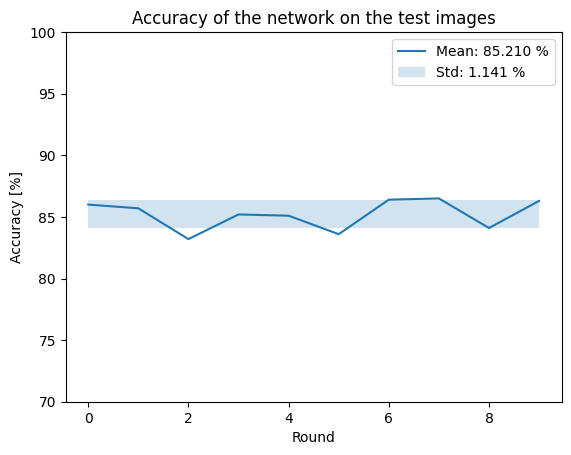

In [7]:
print(f'Mean accuracy of the network on the {len(testloader.dataset)} test images: \
    {torch.mean(torch.tensor(accuracies)):.1f} % (+/- {torch.std(torch.tensor(accuracies)):.1f} %)')

mean = np.mean(accuracies)
std = np.std(accuracies)

plt.figure()
plt.plot(accuracies)
plt.fill_between(range(len(accuracies)), mean-std, mean+std, alpha=0.2)
plt.legend([f'Mean: {mean:.3f} %', f'Std: {std:.3f} %'])
plt.xlabel('Round')
plt.ylabel('Accuracy [%]')
plt.ylim((70, 100))

plt.title('Accuracy of the network on the test images')

In [17]:
from torchsummary import summary
model_view = Net()
summary(model_view)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            41,040
├─Linear: 1-6                            3,240
├─Linear: 1-7                            41
Total params: 67,617
Trainable params: 67,617
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            41,040
├─Linear: 1-6                            3,240
├─Linear: 1-7                            41
Total params: 67,617
Trainable params: 67,617
Non-trainable params: 0

### model saving

In [18]:
# save model parameters
torch.save(net.state_dict(), './Models/cnn_weight_sharing.pt')

In [19]:
# load model parameters
model1 = Net()
model1.load_state_dict(torch.load('./Models/cnn_weight_sharing.pt'))
model1.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
)